## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Data Loading

In [3]:
fire = pd.DataFrame(columns=['image', 'width', 'height', 'label'])

for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/train/fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'fire'}, ignore_index=True)

for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/train/non_fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'non_fire'}, ignore_index=True)

for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/test/fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'fire'}, ignore_index=True)

for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/test/non_fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'non_fire'}, ignore_index=True)

In [4]:
fire.head()

,image,width,height,label
0,dataset/fire_dataset/train/fire\fire.152.png,1024,683,fire
1,dataset/fire_dataset/train/fire\fire.153.png,958,641,fire
2,dataset/fire_dataset/train/fire\fire.154.png,500,333,fire
3,dataset/fire_dataset/train/fire\fire.155.png,940,470,fire
4,dataset/fire_dataset/train/fire\fire.156.png,880,495,fire


### Data Characteristics

In [5]:
fire.shape

(1462, 4)

In [6]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1462 non-null   object
 1   width   1462 non-null   object
 2   height  1462 non-null   object
 3   label   1462 non-null   object
dtypes: object(4)
memory usage: 45.8+ KB


## Data Cleaning

### Convert Data Types

In [7]:
fire['width'] = fire['width'].astype(int)
fire['height'] = fire['height'].astype(int)

## Exploratory Data Analysis (EDA)

### Label

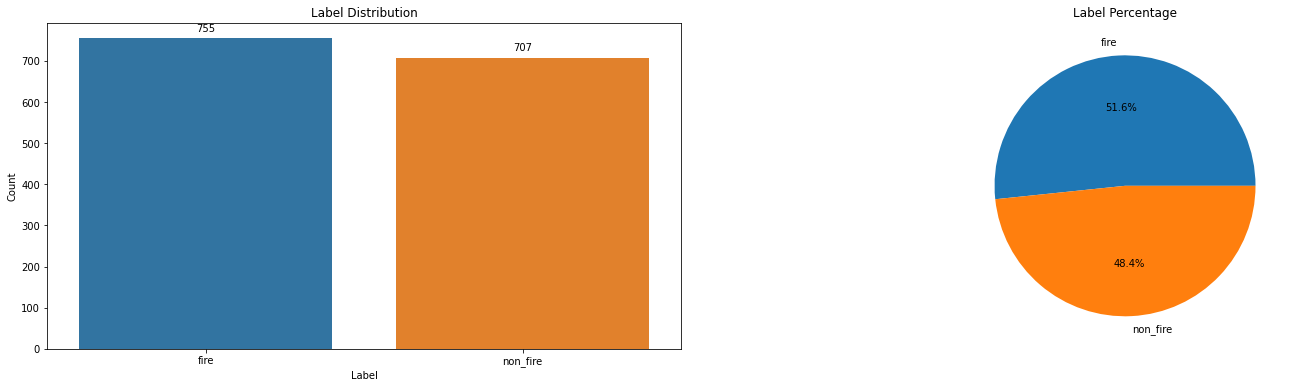

In [8]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x='label', data=fire)
for p in fig.patches:
    fig.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.pie(fire.label.value_counts(), labels=fire.label.value_counts().index, autopct='%1.1f%%')
plt.title('Label Percentage')
plt.show()

### Width and Height

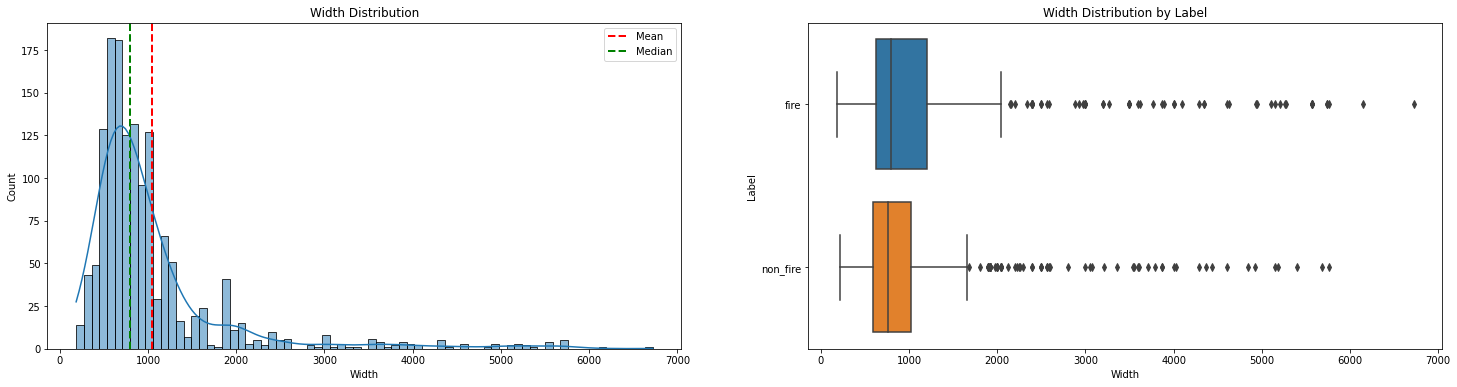

Mean: 1046
Median: 800


In [9]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
sns.histplot(x='width', data=fire, kde=True)
plt.axvline(fire.width.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(fire.width.median(), color='green', linestyle='dashed', linewidth=2, label='Median')
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Count')
plt.legend()
plt.subplot(1, 2, 2)
sns.boxplot(x='width', y='label', data=fire)
plt.title('Width Distribution by Label')
plt.xlabel('Width')
plt.ylabel('Label')
plt.show()
print(f'Mean: {fire.width.mean():.0f}')
print(f'Median: {fire.width.median():.0f}')

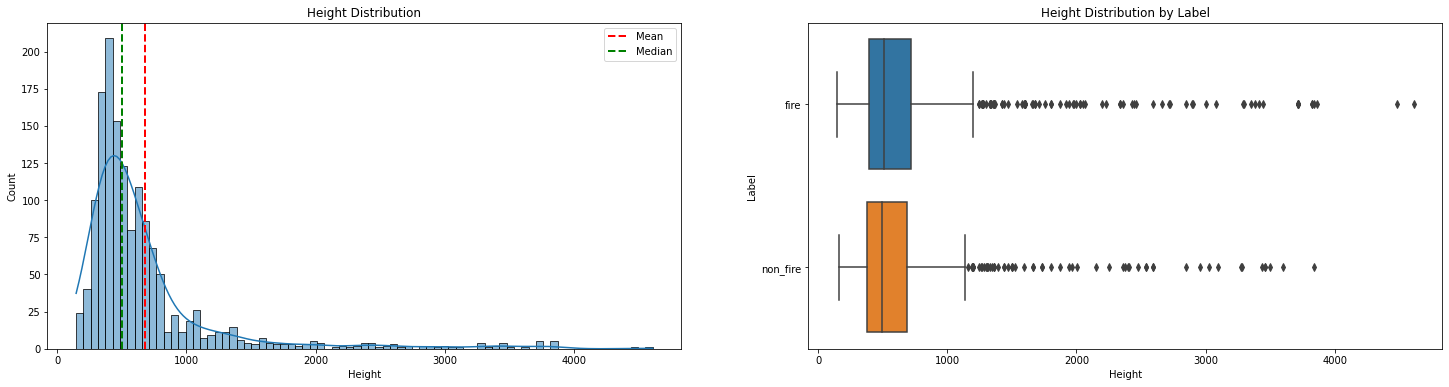

Mean: 678
Median: 500


In [10]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
sns.histplot(x='height', data=fire, kde=True)
plt.axvline(fire.height.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(fire.height.median(), color='green', linestyle='dashed', linewidth=2, label='Median')
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Count')
plt.legend()
plt.subplot(1, 2, 2)
sns.boxplot(x='height', y='label', data=fire)
plt.title('Height Distribution by Label')
plt.xlabel('Height')
plt.ylabel('Label')
plt.show()
print(f'Mean: {fire.height.mean():.0f}')
print(f'Median: {fire.height.median():.0f}')

### Sample Images

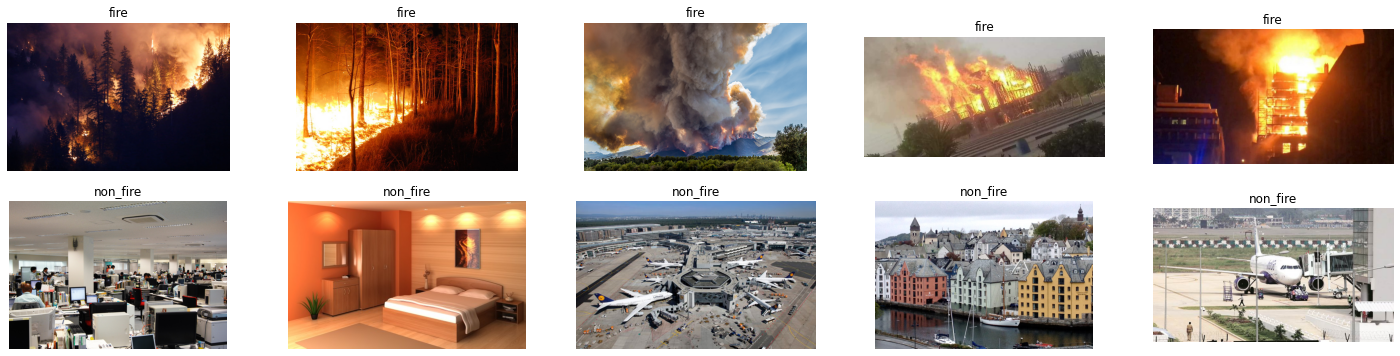

In [11]:
plt.figure(figsize=(25, 6))
counter = 1
for i in ['fire', 'non_fire']:
    for j in range(5):
        plt.subplot(2, 5, counter)
        img = image.load_img(fire[fire.label == i].iloc[j]['image'])
        plt.imshow(img)
        plt.title(i)
        plt.axis('off')
        counter += 1
plt.show()

## Data Preprocessing

In [12]:
train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, width_shift_range=0.4, height_shift_range=0.4, shear_range=0.4, zoom_range=0.4)
valid_gen = ImageDataGenerator(rescale=1./255)

train_dir = 'dataset/fire_dataset/train/'
test_dir = 'dataset/fire_dataset/test/'

train_data = train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=23, class_mode='binary')
valid_data = valid_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=23, class_mode='binary')

Found 1170 images belonging to 2 classes.
Found 292 images belonging to 2 classes.


## Model Definition

In [13]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 16)                2

## Model Training

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=25, validation_data=valid_data)

Epoch 1/25
51/51 [==============================] - 36s 613ms/step - loss: 0.5081 - accuracy: 0.7829 - val_loss: 0.7826 - val_accuracy: 0.7021
Epoch 2/25
51/51 [==============================] - 30s 593ms/step - loss: 0.4017 - accuracy: 0.8368 - val_loss: 0.7186 - val_accuracy: 0.6986
Epoch 3/25
51/51 [==============================] - 30s 585ms/step - loss: 0.4012 - accuracy: 0.8385 - val_loss: 0.5883 - val_accuracy: 0.7534
Epoch 4/25
51/51 [==============================] - 30s 589ms/step - loss: 0.3694 - accuracy: 0.8453 - val_loss: 0.8608 - val_accuracy: 0.7089
Epoch 5/25
51/51 [==============================] - 30s 590ms/step - loss: 0.3930 - accuracy: 0.8410 - val_loss: 0.6582 - val_accuracy: 0.7534
Epoch 6/25
51/51 [==============================] - 30s 588ms/step - loss: 0.3522 - accuracy: 0.8538 - val_loss: 0.7408 - val_accuracy: 0.7603
Epoch 7/25
51/51 [==============================] - 30s 589ms/step - loss: 0.3354 - accuracy: 0.8632 - val_loss: 0.6646 - val_accuracy: 0.7671

## Model Evaluation

In [16]:
metrics = pd.DataFrame(history.history)
metrics.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.267126,0.895727,0.368580,0.839041
21,0.271824,0.894872,0.425410,0.845890
22,0.257672,0.890598,0.452548,0.818493
23,0.264520,0.897436,0.441913,0.828767
24,0.253276,0.900000,0.783592,0.763699


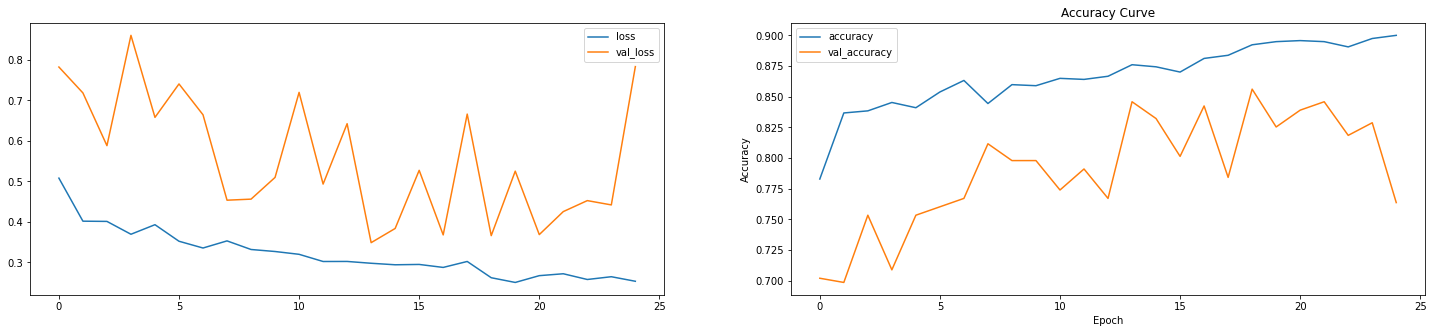

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
metrics[['loss', 'val_loss']].plot(ax=ax[0])
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1])
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

<AxesSubplot:>

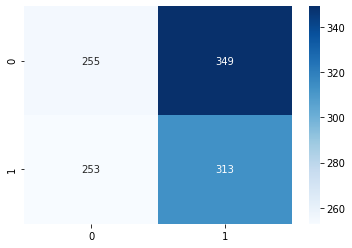

In [18]:
# Confusion Matrix
y_pred = model.predict(train_data)
y_pred = (y_pred > 0.5).astype(int)
y_true = train_data.classes

conf = confusion_matrix(y_true, y_pred)
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')

## Model Improvement

In [47]:
generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

data_dir = 'fire_dataset/'

train_gen = generator.flow_from_directory(data_dir, target_size=(224, 224), batch_size=23, class_mode='binary', subset='training')
valid_gen = generator.flow_from_directory(data_dir, target_size=(224, 224), batch_size=23, class_mode='binary', subset='validation')

Found 1094 images belonging to 2 classes.
Found 273 images belonging to 2 classes.


In [96]:
# Load pretrained model
pretrained_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
pretrained_model.trainable = False

83697664/83683744 [==============================] - 14s 0us/step


In [119]:
# # Create the model
# model = Sequential()
# model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# model.add(Dropout(0.8))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

tf.keras.backend.clear_session()
# Create the model
model = Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_gen, epochs=25, validation_data=valid_gen, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/25
48/48 [==============================] - 25s 449ms/step - loss: 0.2028 - accuracy: 0.9260 - val_loss: 0.0979 - val_accuracy: 0.9634
Epoch 2/25
48/48 [==============================] - 20s 419ms/step - loss: 0.0941 - accuracy: 0.9671 - val_loss: 0.1000 - val_accuracy: 0.9524
Epoch 3/25
48/48 [==============================] - 20s 413ms/step - loss: 0.0684 - accuracy: 0.9799 - val_loss: 0.0857 - val_accuracy: 0.9597
Epoch 4/25
48/48 [==============================] - 20s 422ms/step - loss: 0.0532 - accuracy: 0.9863 - val_loss: 0.0752 - val_accuracy: 0.9744
Epoch 5/25
48/48 [==============================] - 20s 411ms/step - loss: 0.0429 - accuracy: 0.9899 - val_loss: 0.0944 - val_accuracy: 0.9634
Epoch 6/25
48/48 [==============================] - 21s 428ms/step - loss: 0.0364 - accuracy: 0.9927 - val_loss: 0.0951 - val_accuracy: 0.9707
Epoch 7/25
48/48 [==============================] - 21s 429ms/step - loss: 0.0277 - accuracy: 0.9954 - val_loss: 0.0767 - val_accuracy: 0.9744

In [120]:
metrics = pd.DataFrame(history.history)
metrics.tail()

,loss,accuracy,val_loss,val_accuracy
2,0.068376,0.979890,0.085731,0.959707
3,0.053151,0.986289,0.075233,0.974359
4,0.042914,0.989945,0.094434,0.963370
5,0.036382,0.992687,0.095069,0.970696
6,0.027659,0.995430,0.076747,0.974359


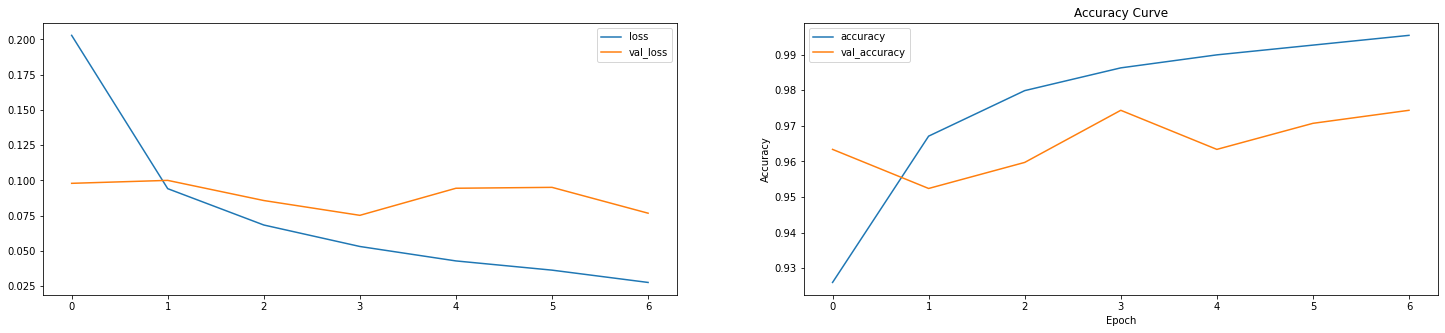

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
metrics[['loss', 'val_loss']].plot(ax=ax[0])
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1])
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

<AxesSubplot:>

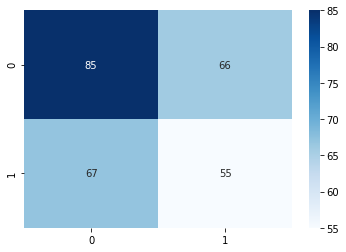

In [122]:
# Confusion Matrix
y_pred = model.predict(valid_gen)
y_pred = (y_pred > 0.5).astype(int)
y_true = valid_gen.classes

conf = confusion_matrix(y_true, y_pred)
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')

## Model Testing

In [123]:
def load_img(filename, img_shape=224):
  img = read_file(filename)
  img = decode_image(img, channels=3)
  img = resize(img, size=[img_shape, img_shape])
  img = img/255.
  return img

In [124]:
img1 = load_img('img1.jpg')
img2 = load_img('img2.jpg')
img3 = load_img('img3.jpg')
img4 = load_img('img4.jpg')
img5 = load_img('img5.jpg')

In [125]:
train_data.class_indices

{'fire': 0, 'non_fire': 1}

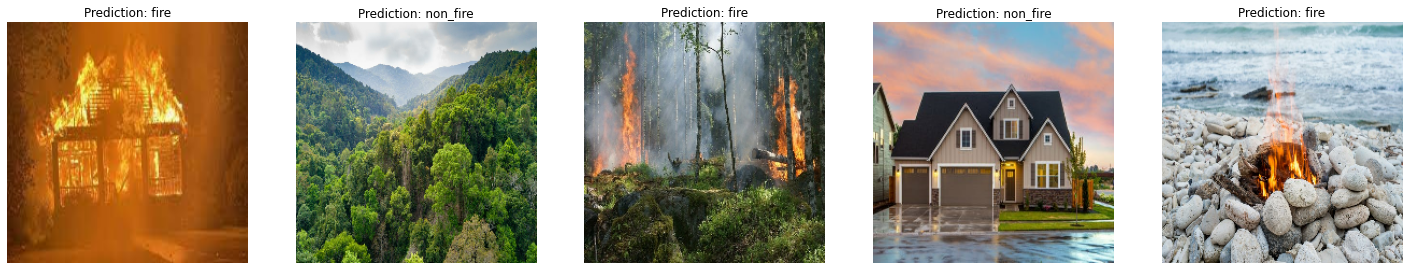

In [126]:
plt.figure(figsize=(25, 6))
counter = 1
for i in [img1, img2, img3, img4, img5]:
    plt.subplot(1, 5, counter)
    res = int(tf.round(model.predict(x=expand_dims(i, axis=0))))
    plt.imshow(i)
    plt.title(f"Prediction: {'fire' if res == 0 else 'non_fire'}")
    plt.axis('off')
    counter += 1
plt.show()  

In [127]:
from PIL import Image
import requests
from io import BytesIO

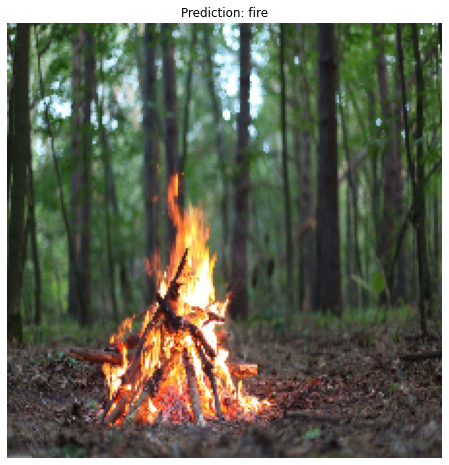

In [139]:
url = "https://revere-health-cdn.sfo2.cdn.digitaloceanspaces.com/iStock_14979700_XXXLARGE.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = np.array(img)
img = resize(img, size=[224, 224])
img = img/255.
plt.figure(figsize=(8, 8))
plt.imshow(img)
res = int(tf.round(model.predict(x=expand_dims(img, axis=0))))
plt.title(f"Prediction: {'fire' if res == 0 else 'non_fire'}")
plt.axis('off')
plt.show()